## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Описание данных

    Данные для первой части
    Файл /datasets/hypothesis.csv.
            * Hypothesis — краткое описание гипотезы;
            * Reach — охват пользователей по 10-балльной шкале;
            * Impact — влияние на пользователей по 10-балльной шкале;
            * Confidence — уверенность в гипотезе по 10-балльной шкале;
            * Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
            
    Данные для второй части
    Файл /datasets/orders.csv. Скачать датасет
            * transactionId — идентификатор заказа;
            * visitorId — идентификатор пользователя, совершившего заказ;
            * date — дата, когда был совершён заказ;
            * revenue — выручка заказа;
            * group — группа A/B-теста, в которую попал заказ.
    Файл /datasets/visitors.csv. Скачать датасет
            * date — дата;
            * group — группа A/B-теста;
            * visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## План выполнения
1. [Открытие и проверка данных](#step_1) 
2. [Приоритизация гипотез](#step_2) 
3. [Анализ A/B-теста]
    - [Кумулятивная выручка по группам](#step_3)
    - [Кумулятивный средний чек по группам](#step_4)
    - [Относительное изменение кумулятивного среднего чека группы B к группе A](#step_5)
    - [Кумулятивная конверсия по группам](#step_6)
    - [Относительное изменение кумулятивной конверсии группы B к группе A](#step_7)
    - [Количество заказов по пользователям](#step_8)
    - [Стоимость заказов по пользователям](#step_9)
    - [Статистическая значимость различий в конверсии между группами по «сырым» данным](#step_10)
    - [Статистическая значимость различий в среднем чеке между группами по «сырым» данным](#step_11)
    - [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#step_12)
    - [Статистическая значимость различий в среднем чеке между группами по «очищенным» данным](#step_13)
4. [Общий вывод](#step_14)


In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import normaltest
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import scipy.stats as stats

### Открытие и проверка данных

In [2]:
# выгрузка данных
hypothesis = pd.read_csv('')
orders = pd.read_csv('')
visitors = pd.read_csv('')

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера: </b>

Спасибо за оглавление, импорты в начале и корректное чтение файлов /div>


<a id='step_1'></a>

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Данные с гипотезами имеют 9 строк без пропусков. Все столбцы с корректными типами данных.

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Данные о заказах имеют 1197 строк без пропусков. Все столбцы, кроме даты заказа, имеют корректный тип данных. Дату приведём к необходимому типу ниже.

In [7]:
# приведение даты к нужному типу
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Данные о посетителях имеют 62 строки без пропусков. Все столбцы, кроме даты, имеют корректный тип данных. Дату приведём к необходимому типу ниже.

In [10]:
# приведение даты к нужному типу
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
print('Дубликатов в данных о гипотезах',hypothesis.duplicated().sum())
print('Дубликатов в данных о заказах',orders.duplicated().sum())
print('Дубликатов в данных о поситителях',visitors.duplicated().sum())


Дубликатов в данных о гипотезах 0
Дубликатов в данных о заказах 0
Дубликатов в данных о поситителях 0


В данных отсуствуют полные дубликаты.

### Приоритизация гипотез

<a id='step_2'></a>

In [12]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis[['Hypothesis','ICE', 'Confidence']].sort_values(by = "ICE", ascending = False)

,Hypothesis,ICE,Confidence
8,"Запустить акцию, дающую скидку на товар в день...",16.200000,9
0,"Добавить два новых канала привлечения трафика,...",13.333333,8
7,Добавить форму подписки на все основные страни...,11.200000,8
6,Показать на главной странице баннеры с актуаль...,8.000000,8
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000,7
1,"Запустить собственную службу доставки, что сок...",2.000000,4
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333,2
3,"Изменить структура категорий, что увеличит кон...",1.125000,3
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000,1


In [13]:
hypothesis['RICE'] = hypothesis['Impact'] * hypothesis['Confidence'] * hypothesis['Reach'] / hypothesis['Efforts']
hypothesis[['Hypothesis','RICE','Reach', 'Confidence']].sort_values(by = "RICE", ascending = False)

,Hypothesis,RICE,Reach,Confidence
7,Добавить форму подписки на все основные страни...,112.0,10,8
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0,8,7
0,"Добавить два новых канала привлечения трафика,...",40.0,3,8
6,Показать на главной странице баннеры с актуаль...,40.0,5,8
8,"Запустить акцию, дающую скидку на товар в день...",16.2,1,9
3,"Изменить структура категорий, что увеличит кон...",9.0,8,3
1,"Запустить собственную службу доставки, что сок...",4.0,2,4
5,"Добавить страницу отзывов клиентов о магазине,...",4.0,3,2
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0,3,1


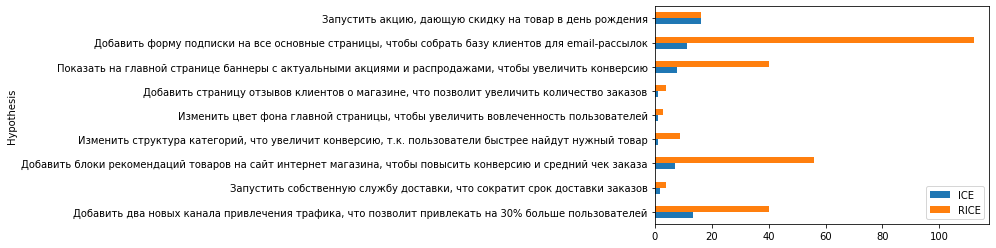

In [14]:
hypothesis.set_index('Hypothesis')[['ICE','RICE']].plot(kind = 'barh')
plt.show()

При приоритезации по методу ICE в лидерах гипотезы 8, 0, 7, 6.

При приоритезации по методу RICE в лидерах гипотезы 7, 2, 0, 6.

Такая разница в результаттах достигается из-за параметра Reach, который отвечает за количество пользователей, которых затронут изменения при реализации гипотезы.

Самыми удачными являются гипотезы 7, 0, 6.

### Анализ A/B-теста

**Кумулятивная выручка по группам** <a id='step_3'></a>

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [16]:
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups
# Агрегируем значения. Вычислим максимальную дату
# Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group'

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 
      'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group']) 

ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [17]:
# Получим строки таблицы visitors, дата которых меньше или равна дате элемента из datesGroups
# Агрегируем значения. Вычислим максимальную дату
# Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group'

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                        .sort_values(by=['date','group']) 
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [18]:
# Объединили данные в ону таблицу и изменили названия столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [19]:
# Разбили данные по группам для постоения графиков

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


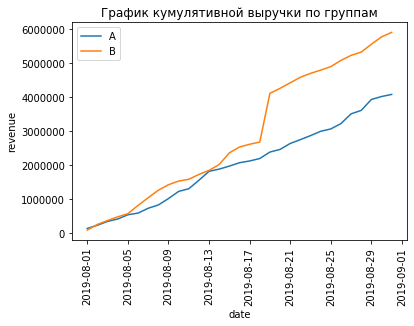

In [20]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('График кумулятивной выручки по группам') 
plt.ylabel('revenue')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста.

Графики выручки группы B в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

**Кумулятивный средний чек по группам**<a id='step_4'></a>

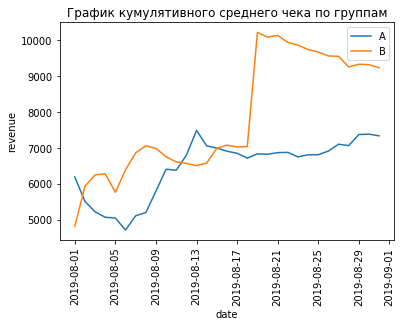

In [21]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('График кумулятивного среднего чека по группам') 
plt.ylabel('revenue')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.show()

Средний чек ведёт себя менее равномерно, чем выручка для обеих групп. Присутствуют скачки. Самый большой скачок у группы B наблюдается в тот же момент, когда и на графике с кумулятивной выручкой. Возможно, в группу B попали крупные заказы (резкий всплеск на графике).

**Относительное изменение кумулятивного среднего чека группы B к группе A**<a id='step_5'></a>

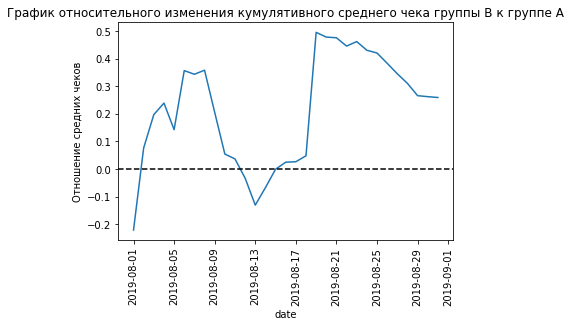

In [22]:
# собираем данные в одном датасете
# cтроим отношение средних чеков
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А') 
plt.ylabel('Отношение средних чеков')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.show()

На графике видны резкие скачки, возможно там есть крупные заказы, которые искажают общу картину.

Изначально средний чек группы В был меньше на 20%. Затем средний чек группы В стал увеличиваться, относительно группы А. В середине эксперимента н был в 2 раза больше за счёт аномальных заказов. К концу эксперимента средний чек группы В на 20% стал больше, чем седний чек группы А.

**Кумулятивная конверсия по группам**<a id='step_6'></a>

In [23]:
# считаем кумулятивную конверсию
# разделяем её по группам
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

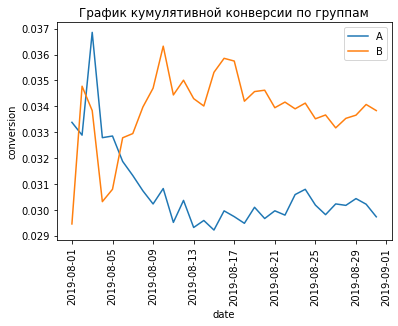

In [24]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend() 
plt.title('График кумулятивной конверсии по группам') 
plt.ylabel('conversion')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.show()



Конверсия группы А изначально была выше, но затем значительно упала. Конверсия группы В резко выросла и пошла на медленное снижение.

**Относительное изменение кумулятивной конверсии группы B к группе A**<a id='step_7'></a>

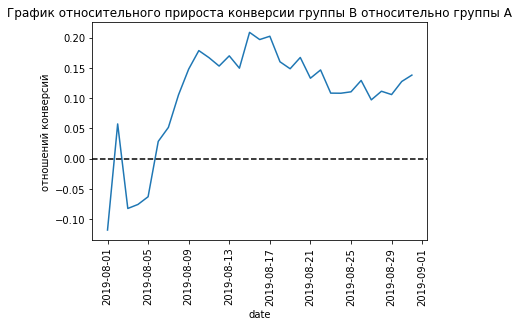

In [25]:
# собираем данные в одном датасете
# cтроим отношение конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', right_on='date', how='left', 
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
 
plt.title('График относительного прироста конверсии группы B относительно группы A') 
plt.ylabel('отношений конверсий')
plt.xlabel('date')
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


В начале теста конверсия группы В была меньше, чем конверсия группы А. Но уже в остальное время теста, конверсия группы В преобладала над конверсией группы А.

**Количество заказов по пользователям**<a id='step_8'></a>

In [26]:
# количество заказов на каждого пользователя
# избавляемся от лишних столбцов
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsers.columns = ['visitorId', 'transactions']
ordersByUsers

,visitorId,transactions
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1
...,...,...
1026,4266935830,2
1027,4278982564,1
1028,4279090005,1
1029,4281247801,1


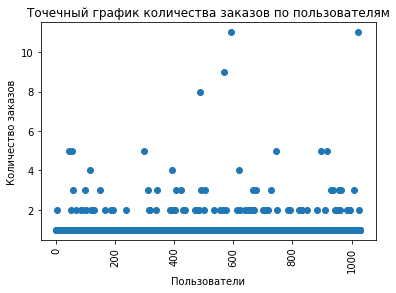

In [27]:
# ось x покупатели
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['transactions']) 

plt.title('Точечный график количества заказов по пользователям') 
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи')
plt.xticks(rotation='vertical')
plt.show()

Чаще всего люди делают 1-2 заказа, 3-4 уже редкость. 

Всё, что больше 5 заказов, скорее всего, даёт выбросы.

In [28]:
print('95-й и 99-й перцентили количества заказов на пользователя:',np.percentile(ordersByUsers['transactions'], [95, 99]))

95-й и 99-й перцентили количества заказов на пользователя: [2. 4.]


Меньше 1% пользователей совершают более 4-х заказов. Меньше 5% пользователей совершают более 2-х заказов. 

Пользователей, с количеством заказов больше 4-х, можно считать аномальными. 

**Стоимость заказов по пользователям**<a id='step_9'></a>

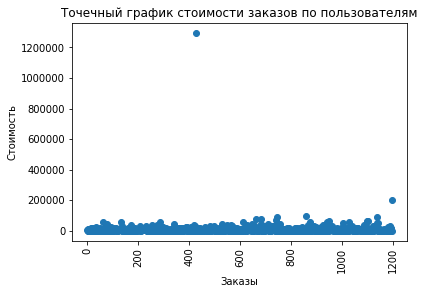

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Точечный график стоимости заказов по пользователям') 
plt.ylabel('Стоимость')
plt.xlabel('Заказы')
plt.xticks(rotation='vertical')
plt.show()

На графике видно, что есть как минимум два выбивающихся заказа с очень высокой стоимостью.

In [30]:
print('95-й и 99-й перцентили стоимости заказов:',np.percentile(orders['revenue'], [95, 99])) 

95-й и 99-й перцентили стоимости заказов: [28000.  58233.2]


Всего 5% заказов дороже 28000, 1% заказов дороже 58000. Заказы дороже 28000 будем считать аномальными.

**Работа с сырыми данными**

In [31]:
# Посетителей в день по группам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsADaily.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [32]:
# количество покупателей суммарное  
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitorsPerDateA': 'sum'}),axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [33]:
# сумма заказов по дням по группам
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}))

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [34]:
# количество заказов по дням суммарное(до выбранной даты)
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                                        .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),axis=1,).sort_values(by=['date'])
ordersACummulative.columns = ['date','ordersCummulativeA','revenueCummulativeA',]

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                                        .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),axis=1,).sort_values(by=['date'])
ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB',]
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [35]:
# Объединим все эти данные в одну таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


**Статистическая значимость различий в конверсии между группами по «сырым» данным**<a id='step_10'></a>

In [36]:
# пользователи, которые хотя бы раз совершали покупки по группам
ordersByUsersA = (orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsersA.columns = ['visitorId', 'transactions']

ordersByUsersB = (orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique}))

ordersByUsersB.columns = ['visitorId', 'transactions'] 

In [37]:
# Последовательности состоящие из количества заказов пользователей, совершавших покупки,и нулей для пользователей,
# которые не совершили ни одной покупки.
sampleA = pd.concat([ordersByUsersA['transactions'],pd.Series(0, index=np.arange(data['visitorsPerDateA']
                                                                           .sum() - len(ordersByUsersA['transactions'])), name='transactions')],axis=0)

sampleB = pd.concat([ordersByUsersB['transactions'],pd.Series(0, index=np.arange(data['visitorsPerDateB']
                                                                           .sum() - len(ordersByUsersB['transactions'])), name='transactions')],axis=0)




Примем за нулевую гипотезу:статисчтически значимых различий между группами нет.

In [38]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
p_value_raw = stats.mannwhitneyu(sampleA, sampleB)[1]
if p_value_raw < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между группами есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет')
          
print('Относительный выигрыш группы B:',"{0:.1%}".format(sampleB.mean() / sampleA.mean() - 1))          
          

0.008
Отвергаем нулевую гипотезу, статистически значимые различия между группами есть
Относительный выигрыш группы B: 13.8%


Различия между группами А и В есть. Это доказал критерий Манна-Уитни и отношении средней конверсии группы В к А.

**Статистическая значимость различий в среднем чеке между группами по «сырым» данным**<a id='step_11'></a>

In [39]:
p_value_raw_rev = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print(p_value_raw_rev)
if p_value_raw_rev < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между группами есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет')
    
print('Относительный выигрыш группы B:','{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))     

0.3646454927716229
Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет
Относительный выигрыш группы B: 25.9%


По сырым данным статистически значимых различий между чеками нет. Хотя отношение средних чеков говорит об обратном: средний чек группы В значительно выше. Это мы могли видеть на графиках выше.

**Очистка данных**

Аномальными мы посчитали пользователей, которые делают больше 4-х заказов, а аномальная стоимость заказа - более 28000.

In [40]:
# Аномальные заказы

usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['transactions'] > 4]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['transactions'] > 4]['visitorId'],],axis=0,)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

#print(abnormalUsers.head(5))
print('Количество аномальных пользователей', abnormalUsers.shape) 

Количество аномальных пользователей (59,)


In [41]:
# Очистка данных от аномальных заказов и пользователей
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['transactions'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactions'])),name='transactions',),],axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['transactions'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactions'])),name='transactions',),],axis=0,)

sampleAFiltered

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: transactions, Length: 18703, dtype: int64

**Статистическая значимость различий в конверсии между группами по «очищенным» данным**<a id='step_12'></a>

In [42]:
p_value_filtered = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print(p_value_filtered)
if p_value_filtered < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между группами есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет')
          
print('Относительный выигрыш группы B:',"{0:.1%}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))  

0.009228541744275084
Отвергаем нулевую гипотезу, статистически значимые различия между группами есть
Относительный выигрыш группы B: 14.5%


Результаты по конверсии по очищенным и сырым данным почти не отлиаются. Различия между группами есть.

**Статистическая значимость различий в среднем чеке между группами по «очищенным» данным**<a id='step_13'></a>

In [43]:
p_value_filtered_rev = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]
print(p_value_filtered_rev)
if p_value_filtered_rev < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между группами есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет')
    
print('Относительный выигрыш группы B:',"{0:.1%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1))     

0.48063712440904605
Не отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет
Относительный выигрыш группы B: -1.4%


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера: </b>

Кроме того, что результат корректный, так еще и твой код восхитителен! ПОлагаю, ты давно знаешь о РЕР8, но если нет - обязательно обрати внимание ;)

</div>


Статистически зачимых различий между средними чеками группы А и В опять не найдено. И действительно, отношение средних чеков в очищенных данных стало значительно меньше. Отфильтрованные заказы вносили сильный шум.

### Общий выводы

<a id='step_14'></a>

    - Есть статистически значимые различия по конверсии между группами по «сырым» и по данным после фильтрации аномалий;
    - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий; 
    - После фильтрации аномалий разница между средним чеком группы А и В сильно уменьшилась;
    - График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к ухудшению:
    - График различия среднего чека колеблется: он-то и позволил вам найти аномалии. 
    
**Результат А/В теста: признать тест успешным: конверсия группы В значительно на 10-15% выше, чем конверсия группы А.**

 Результат А/В теста: признать тест успешным: конверсия группы В значительно на 10-15% выше, чем конверсия группы А. Тест можно завершить, так как график конверсии устоялся и имеет предсказуемые тенденции.